In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from libs.tools import *
from libs.network import *
import torch
from geopy.distance import geodesic
from scipy import spatial
import copy

/home/ids/yukliu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# opendata_triplets = np.load('/home/ids/yukliu/OpenTest/data/opendata_triplets.npy')


In [2]:
bs = 256
embed_dim = 8
suffix = 'OpenDataTest_OfflineMining_MetricLearning'

In [15]:
class MetricNet(nn.Module):
    def __init__(self, in_feats, out_dim=1, hiddens=[64, 32]):
        super().__init__()
        self.name = "MetricNet"
        out_dim = 1
        in_feats = in_feats * 2
        th.set_default_dtype(th.float32)
        assert len(hiddens) > 1
        list_FC_layers = [nn.Linear(in_feats, hiddens[0]), nn.ReLU()]
        n_hiddens = len(hiddens)
        for l in range(n_hiddens - 1):
            list_FC_layers.append(nn.Linear(hiddens[l], hiddens[l+1]))
            list_FC_layers.append(nn.ReLU())
            list_FC_layers.append(nn.BatchNorm1d(hiddens[l+1]))
        list_FC_layers.append(nn.Linear(hiddens[n_hiddens - 1], out_dim))
        list_FC_layers.append(nn.ReLU())
        # list_FC_layers.append(nn.BatchNorm1d(out_dim))
        self.model = nn.Sequential(*list_FC_layers)


    def sys_forward(self, x, y):
        d_xy = self.model.forward(th.cat((x,y), -1))
        d_yx = self.model.forward(th.cat((y,x), -1))
        return (d_xy + d_yx) / 2


    def forward(self, x, y, z):
        # return th.exp(self.model.forward(X))
        d_xy = self.model.forward(th.cat((x,y), -1))
        # d_yx = self.model.forward(th.cat((y,x), -1))

        d_xz = self.model.forward(th.cat((x,z), -1))
        # d_zx = self.model.forward(th.cat((z,x), -1))

        # d_xy = self.sys_forward(x, y)
        # d_xz = self.sys_forward(x, z)

        # d_sym_xy = (d_xy + d_yx) / 2
        # d_sym_xz = (d_xz + d_zx) / 2
        return d_xy, d_xz
    
    def get_embedding(self, x, y):
        if not th.is_tensor(x):
            x = th.tensor(x, dtype=th.float32)
        if not th.is_tensor(y):
            y = th.tensor(y, dtype=th.float32)
        d = (self.model.forward(th.cat((x, y), -1)) + self.model.forward(th.cat((y, x), -1))) / 2
        return d

In [3]:
m = torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_{embed_dim}_m_2_bs_{bs}_{suffix}.sav')

for k, v in m.items():
    print(k, v.shape)

model.0.weight torch.Size([512, 2048])
model.0.bias torch.Size([512])
model.2.weight torch.Size([256, 512])
model.2.bias torch.Size([256])
model.4.weight torch.Size([64, 256])
model.4.bias torch.Size([64])
model.6.weight torch.Size([1, 64])
model.6.bias torch.Size([1])


In [4]:
dim_1 = 1024
hiddens=[512, 256, 64]
# hiddens=[512, 256, 128, 64, 32]
# hiddens=[512, 256, 64, 32]

triplet_net_tmp = MetricNet(dim_1, out_dim=1, hiddens=hiddens)
triplet_net_tmp.load_state_dict(torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_{embed_dim}_m_2_bs_{bs}_{suffix}.sav'))

<All keys matched successfully>

# Load data

In [5]:
meta_data = pd.read_csv('./data/dichasus.csv')
# meta_data = pd.read_csv('./data/Opendata_3.csv')
csi_cols = [col for col in meta_data.columns if col not in ['Unnamed: 0', 'time', 'x', 'y']]
csi_data = meta_data[csi_cols].values
locations = meta_data[['x', 'y']].values

In [6]:
csi_data = torch.tensor(csi_data, dtype=th.float32)

## Evaluation

In [7]:
from sklearn.neighbors import KNeighborsRegressor


In [8]:
locations = th.tensor(locations, dtype=th.float32)

In [9]:
metric_fn = triplet_net_tmp.get_embedding

In [23]:
num = 20000
d_ls = []
c_ls = []
for i in range(num):
    ids = np.random.choice(len(csi_data), 2)
    c1, c2 = csi_data[ids[0]], csi_data[ids[1]]
    metric_d = metric_fn(c1, c2).detach().numpy()[0]
    d = np.linalg.norm(locations[ids[0]]-locations[ids[1]])
    d_ls.append(d)
    c_ls.append(metric_d)

In [20]:

def distance_ci_visualization(distances_flat, dissimilarities_flat):
    max_distance = np.max(distances_flat)
    bins = np.linspace(0, max_distance, 200)
    bin_indices = np.digitize(distances_flat, bins)

    bin_medians = np.zeros(len(bins) - 1)
    bin_25_perc = np.zeros(len(bins) - 1)
    bin_75_perc = np.zeros(len(bins) - 1)
    for i in range(1, len(bins)):
        try:
            bin_values = dissimilarities_flat[bin_indices == i]
            bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
        except:
            print('break')
            break

    return bins[:i-1], bin_medians[: i-1], bin_25_perc[:i-1], bin_75_perc[:i-1]

def draw_ci_plot(d, c, ax=plt, label=None):
    bins, medians, perc_25, perc_75 = distance_ci_visualization(d, c)
    ax.plot(bins, medians, label=label)
    ax.fill_between(bins, perc_25, perc_75, alpha=0.5)
    ax.xlabel('Euclidean distance')
    ax.ylabel('Metric distance')
    ax.grid()

In [24]:
distance_ci_visualization(d_ls, c_ls)

break


(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

In [13]:
from offline_mining_tools import *

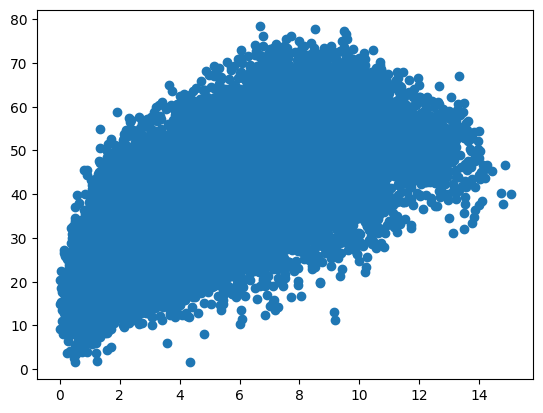

In [25]:
plt.scatter(d_ls, c_ls)

In [16]:
distance_ci_visualization(d_ls, c_ls)

(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

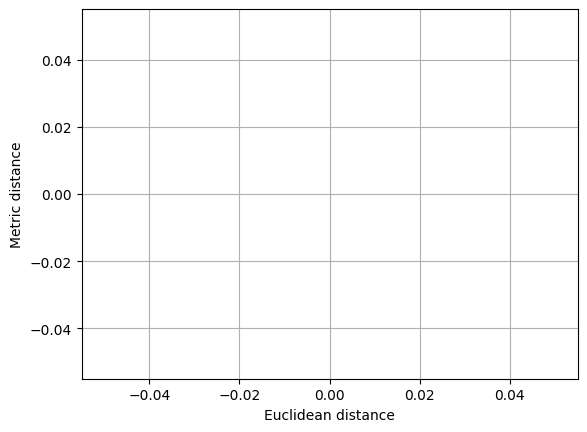

In [14]:
draw_ci_plot(d_ls, c_ls)

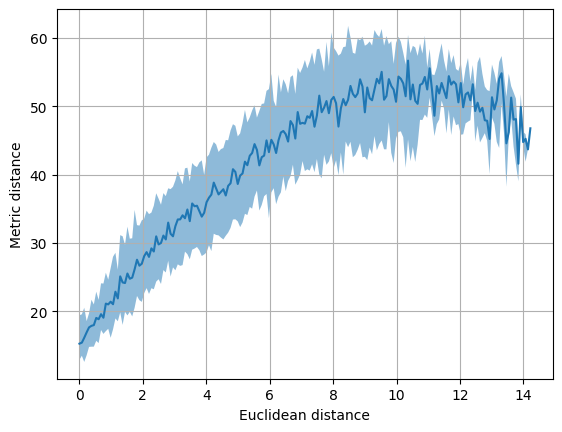

In [26]:
distances_flat = np.array(d_ls)
dissimilarities_flat = np.array(c_ls)
max_distance = np.max(distances_flat)
bins = np.linspace(0, max_distance, 200)
bin_indices = np.digitize(distances_flat, bins)

bin_medians = np.zeros(len(bins) - 1)
bin_25_perc = np.zeros(len(bins) - 1)
bin_75_perc = np.zeros(len(bins) - 1)
for i in range(1, len(bins)):
    try:
        bin_values = dissimilarities_flat[bin_indices == i]
        bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
    except:
        break

plt.plot(bins[:i-1], bin_medians[: i-1], label = 'Metric distance')
plt.fill_between(bins[:i-1], bin_25_perc[:i-1], bin_75_perc[:i-1], alpha=0.5)
plt.xlabel('Euclidean distance')
plt.ylabel('Metric distance')
plt.grid()
# plt.savefig('./result/metric_distance_relation.pdf')

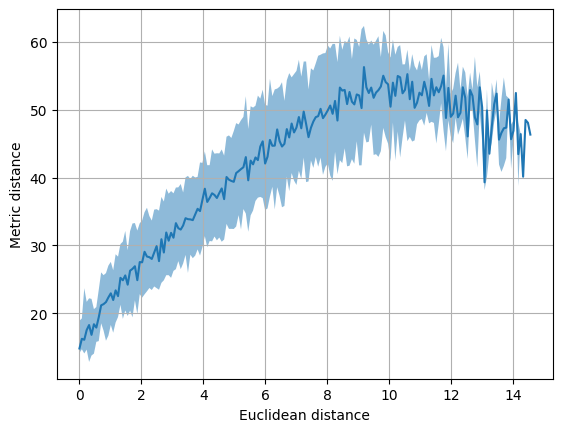

In [13]:
distances_flat = np.array(d_ls)
dissimilarities_flat = np.array(c_ls)
max_distance = np.max(distances_flat)
bins = np.linspace(0, max_distance, 200)
bin_indices = np.digitize(distances_flat, bins)

bin_medians = np.zeros(len(bins) - 1)
bin_25_perc = np.zeros(len(bins) - 1)
bin_75_perc = np.zeros(len(bins) - 1)
for i in range(1, len(bins)):
    try:
        bin_values = dissimilarities_flat[bin_indices == i]
        bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
    except:
        break

plt.plot(bins[:i-1], bin_medians[: i-1], label = 'Metric distance')
plt.fill_between(bins[:i-1], bin_25_perc[:i-1], bin_75_perc[:i-1], alpha=0.5)
plt.xlabel('Euclidean distance')
plt.ylabel('Metric distance')
plt.grid()
# plt.savefig('./result/metric_distance_relation.pdf')

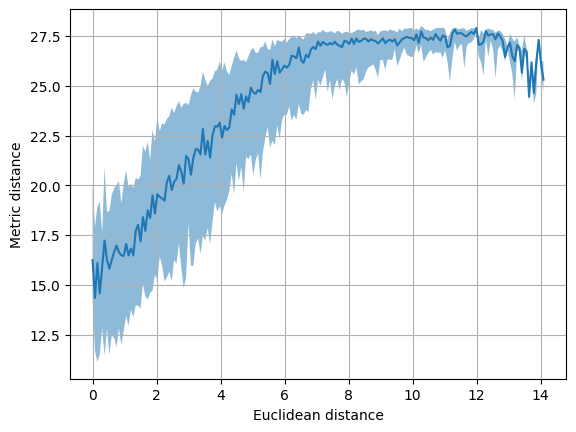

In [103]:
distances_flat = np.array(d_ls)
dissimilarities_flat = np.array(c_ls)
max_distance = np.max(distances_flat)
bins = np.linspace(0, max_distance, 200)
bin_indices = np.digitize(distances_flat, bins)

bin_medians = np.zeros(len(bins) - 1)
bin_25_perc = np.zeros(len(bins) - 1)
bin_75_perc = np.zeros(len(bins) - 1)
for i in range(1, len(bins)):
    try:
        bin_values = dissimilarities_flat[bin_indices == i]
        bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
    except:
        break

plt.plot(bins[:i-1], bin_medians[: i-1], label = 'Metric distance')
plt.fill_between(bins[:i-1], bin_25_perc[:i-1], bin_75_perc[:i-1], alpha=0.5)
plt.xlabel('Euclidean distance')
plt.ylabel('Metric distance')
plt.grid()
# plt.savefig('./result/metric_distance_relation.pdf')

In [99]:
dic = {}
dic['bins'] = bins[:i-1]
dic['medians'] = bin_medians[:i-1]
dic['25'] = bin_25_perc[:i-1]
dic['75'] = bin_75_perc[:i-1]

# Distance metric comparision
- Triplet learnt metric
- embedding euclidean metric (triplets by time)
- embedding euclidean metric (triplets by distance)

In [8]:
dict_metric = np.load('./data/metric_distance_dist.npy', allow_pickle=True).item()
dict_triplet_time = np.load('./data/triplet_time_dist.npy', allow_pickle=True).item()
dict_triplet_distance = np.load('./data/triplet_distance_dist.npy', allow_pickle=True).item()

In [ ]:
plt.plot(bins[:i-1], bin_medians[: i-1], label = 'Metric distance')
plt.fill_between(bins[:i-1], bin_25_perc[:i-1], bin_75_perc[:i-1], alpha=0.5)
plt.xlabel('Euclidean distance')
plt.ylabel('Metric distance')

In [10]:
def read_dict(dic, ax=plt, alpha=.5, label=None):
    bins = dic['bins']
    medians = dic['medians']
    p_25 = dic['25']
    p_75 = dic['75']
    ax.plot(bins, medians, label=label)
    ax.fill_between(bins, p_25, p_75, alpha=alpha)

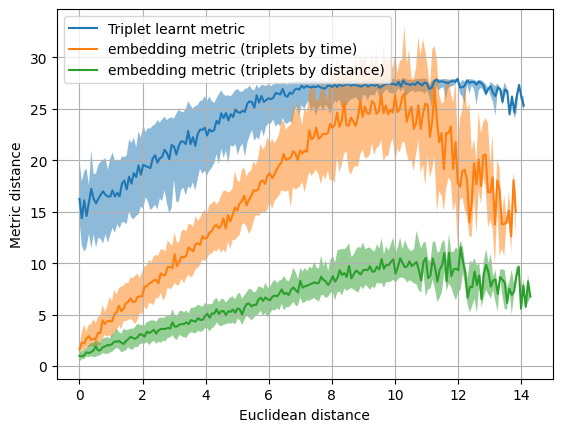

In [150]:
read_dict(dict_metric, label='Triplet learnt metric')
read_dict(dict_triplet_time, label='embedding metric (triplets by time)')
read_dict(dict_triplet_distance, label='embedding metric (triplets by distance)')
plt.xlabel('Euclidean distance')
plt.ylabel('Metric distance')
plt.legend()
plt.grid()
# plt.savefig('./result/metric_distance_relation_all.pdf')
# plt.legend(['Triplet learnt metric',None, 'Euclidean embedding metric'])

## kNN with learnt metric

In [28]:
cc_train, cc_test, pos_train, pos_test = train_test_split(csi_data, locations, random_state=24)
knr = KNeighborsRegressor(n_neighbors=5, metric=triplet_net_tmp.get_embedding)
knr.fit(cc_train, pos_train)

KNeighborsRegressor(metric=<bound method MetricNet.get_embedding of MetricNet(
  (model): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)>)

In [29]:
rd_idx = np.random.choice(len(cc_test), 100)
cc_rd = cc_test[rd_idx]

In [30]:
d_pred = knr.predict(cc_rd)

In [ ]:
cdf_plot(d_pred)